In [7]:
import numpy as np
import tensorflow as tf

2023-02-06 17:29:54.984698: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-06 17:29:56.827526: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-02-06 17:30:11.130223: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /software/gmp/6.2.1/b1/lib:/software/glpk/4.65/lib:/software/zmq/4.2.3/b1/lib:/software/git/2.30.1/lib64:/software/gcc/7.3.0/lib64:/software/gcc/7.3.0/lib:/software/openmpi/4.0.4/b1/lib:/software/cuda/11.4/usr/lo

In [2]:
RNs_found = np.load('../saved_models/shp2-rnn/spy_RNs_sampling.npy')

In [8]:
json_file = open('../saved_models/shp2-rnn/spy_model_sampling.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = tf.keras.models.model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights('../saved_models/shp2-rnn/spy_model_weights_sampling.h5') 
print("Loaded model from disk")

2023-02-06 17:31:24.538616: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-06 17:31:27.550214: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38403 MB memory:  -> device: 0, name: A100-SXM4-40GB, pci bus id: 0000:01:00.0, compute capability: 8.0
2023-02-06 17:31:27.551832: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 30362 MB memory:  -> device: 1, name: A100-SXM4-40GB, pci bus id: 0000:41:00.0, compute capability: 8.0
2023-02-06 17:31:27.553111: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 

Loaded model from disk


In [5]:
np.unique(RNs_found, axis=0).shape

(427, 190)

In [10]:
def counts_aa(vec):
    counts =  tf.histogram_fixed_width(vec, [0, 20], nbins=21)[1:]
    return counts /tf.reduce_sum(counts)

y_hat_RN = loaded_model.predict([RNs_found, np.array([counts_aa(xi) for xi in RNs_found])])

2023-02-06 17:33:34.833122: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8204
2023-02-06 17:33:41.666528: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


14/14 [==============================] - 15s 5ms/step


(array([378.,   4.,   3.,   7.,   1.,   2.,   3.,   4.,   6.,  19.]),
 array([0.00772913, 0.09186593, 0.17600273, 0.26013952, 0.3442763 ,
        0.4284131 , 0.5125499 , 0.59668666, 0.6808235 , 0.7649603 ,
        0.8490971 ], dtype=float32),
 <BarContainer object of 10 artists>)

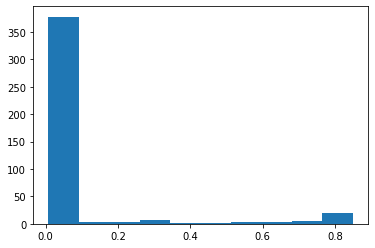

In [12]:
import matplotlib.pyplot as plt
plt.hist(y_hat_RN)

In [37]:
def decoder(seq_vector):
  alphabet = ['A','R','N','D','C','Q','E','G','H','I', 'L','K','M','F','P','S','T','W','Y','V']
  seq = []
  for i, index in enumerate(seq_vector.astype('int')):
    if index == 0:
      break
    seq.append(alphabet[index-1])
  seq = ''.join(seq)
  return seq

In [38]:
indices_sorted = np.argsort(y_hat_RN,axis=0)
# 5 most probable RN
most_likely_RN =  RNs_found[indices_sorted][:5]
# 5 least probable RN
least_likely_RN =  RNs_found[indices_sorted][-5:]

In [41]:
for vec in most_likely_RN:
    print(decoder(vec[0,:]))

TYQIIY
NTMAYL
WVLYWM
LQMYWMY
QWMMM


In [42]:
for vec in least_likely_RN:
    print(decoder(vec[0,:]))

WMYLI
WMMNI
WIRAI
RAIAI
NVIPM
